# <center>Dissolution</center>

### <center>     From Bill's dissolution algorithm document<br>     August 2015 </center>

## <u>Summary</u>

ADIOS3 replaces the ADIOS2 formulas by an expanded version of the new SOLUTE-SINK or BM model of LSU<br>
(Thibodeaux and Overton, 2014; Stevens, 2013; Stevens et al 2015)<br>
The BM model separates the spilled oil into volumes that will dissolve and volumes that will not dissolve.

Based upon estimated low Biot numbers, early MacKay studies, and recent LSU research (Loebig, 2015), practical dissolution is only dependent upon:
<ol>
    <li>The oil-water surface resistance</li>
    <li>Is limited to aromatics</li>
    <li>Decreases with increasing carbon number</li>
</ol>
<i>(Note: Assumption 1 may not be true for very viscous, thick oil slicks)</i>

According to Cohen et al (1980), equation 19,
we can estimate mass transfer rate of the soluble component N $(kg/(m^2 \cdot sec))$ as:

$$
\begin{align}
k_w &= \text{water phase transfer velocity} (m/sec) \cr
& \hphantom{==} \text{(taken as the Stokes velocity for the individual droplet)} \cr
K_{ow} &= \text{partition coefficient} (C_{oil}/C_w) \cr
C_{oil} &= \text{saturation concentration in oil} (kg/m^3) \cr
C_w &= \text{saturation concentration in water} (kg/m^3) \cr
\cr
N &= k_w \cdot C_{oil} / K_{ow} \cr
\end{align}
$$

Note that ADIOS3 uses a partition coefficient that compares mass concentration ratios, not mole concentrations.
However, mass concentrations are related to the molar concentrations through the component's molecular weight.

$$ C_{oil} = molWt \cdot Cmol_{oil} $$

so that the two dimensionless partition coefficients are equivalent.

Lee et al (1992), Eq. 4, relates the partition coefficient to the molar concentration in the oil phase and the molar solubility in the water phase.  However, the same form holds for mass concentrations and mass solubility.

$$
K_{ow} = {C_{oil} \over X_{oil} \cdot S_w}
$$

where:
$$
\begin{align}
X_{oil} &= \text{mass fraction of the particular hydrocarbon} \cr
S_w &= \text{aqueous solubility} (kg / m^3) \cr
\end{align}
$$

Dissolution may occur from the bottom of the surface slick and from the surface of dispersed oil droplets.
If one compares specific saturate hydrocarbons to aromatic hydrocarbons with similar molecular weight,
e.g n-octane with mw of 114 and toluene with mw of 92,
one finds that the partition coefficient of the saturate is orders of magnitude smaller than that for the weight equivalent aromatic;
$ 10^{-6} $ for n-octane versus $ 10^{-3} $ for toluene.<br>
Therefore, ADIOS3 treats non-aromatic compounds as essentially insoluble.

Among aromatics, the partition coefficient decreases with an increase in density.  ADIOS3 combines correlations by Huibers and Katritzky (1998) and Lee et al (1992) to estimate the correlation between a specific aromatic hydrocarbon's density and molecular weight with its partition coefficient.

$$
\begin{align}
\rho_{arom} &= \text{Density of aromatic} \cr
molWt &= \text{Molecular Weight} \cr
S &= \text{Solubility} \cr
\cr
S &= Huibers(\rho_{arom}, molWt) \cr
K_{ow} &= Lee(S) \cr
&= Lee(Huibers(\rho_{arom}, molWt))
\end{align}
$$

Huibers relates solubility (moles/liter) to molar volume, $ mv $, measured in cubic angstroms.
Assuming that molar volume can be expressed as molecular weight, $ molWt $, divided by density, $ \rho $, and using proper mks units for molecular weight $ (kg/kmole) $ and density $ (kg/m^3) $ we get:

$$
\begin{align}
mv &= {molWt \over \rho} = \text{Molar Volume} \cr
\cr
S_w &\propto 10^{-0.038mv} \cr
&\propto (10^{-0.038})^{mv} \cr
&\propto (e^{-0.087})^{mv} \cr
&\propto e^{-0.087mv} \cr
&\text{and so finally we get...} \cr
S_w &\propto exp \left( -0.087 \cdot {molWt \over \rho} \right) \cr
\end{align}
$$

Lee et al (Eq. 5) relates $ K_{ow} $ to $ S_w $ as:

$$
\begin{align}
K_{ow} &= {\rho \over S_w \cdot molWt } \cr
\end{align}
$$

<br><br><br><br><br><br><br><br>

And Combining the two equations gives:

$$
\begin{align}
K_{ow} &= A \cdot \left( {\rho \over exp \left( -0.087 \cdot {molWt \over \rho} \right) \cdot molWt } \right) \cr
&\text{and solving for A...} \cr
A &= {K_{ow} \cdot exp \left( -0.087 \cdot {molWt \over \rho} \right) \cdot molWt \over \rho} \cr
\end{align}
$$

where $A$ is determined empirically.

ADIOS3 separates the aromatics into distillation cut components.  For any component $ j $, molecular weight and density are part of the ADIOS3 oil property database, usually by approximation from other properties.

Using the measured values of a known aromatic such as toluene, for example, with a molecular weight of 92.1 $ kg/kmole$ , density of 866 $ kg/m^3 $, and $ K_{ow(j)} $ of 1000, the constant $ A $ can be estimated as 105.37 (as shown below).

In [1]:
import numpy as np
mol_wt = 92.1
density = 866.0
k_ow = 1000.0

print (k_ow * np.exp(-0.087 * mol_wt / density) * mol_wt) / density

105.371560294


So if we quickly compile the above formula reductions, we get the following:

In [2]:
class LeeHuibers(object):
    @classmethod
    def partition_coeff(cls, mol_wt, density):
        '''
            :param mol_wt: Molecular weight in kg/kmole
            :param density: Density in kg/m^3
        '''
        return 105.372 * density / (np.exp(-0.087 * mol_wt / density) * mol_wt)

print LeeHuibers.partition_coeff(92.1, 866.0)

1000.00417291


Given that ADIOS3 will approximate both density and molecular weight from distillation cut temperatures, it makes sense to compute $ K_{ow} $ directly from the distillation cuts.

Using Riazi (2005), aromatic molecular weight can be approximated from distillation cut temperature $ T_j $ (in Kelvin) as:

$$
\begin{align}
molWt_j &= 350 \cdot (6.98 - ln(1070 - T_j))^{3/2}
\end{align}
$$

and aromatic density $ (kg/m^3) $ as:

$$
\begin{align}
\rho_j &= 100 \cdot T_j^{1/3}
\end{align}
$$

Setting $ \lambda_j = {molWt_j \over \rho_j} $, the graph of $ \lambda_j $ over the typical range of distillation cuts looks like the following:

In [3]:
class Riazi(object):
    @classmethod
    def mol_wt(cls, temp):
        return 350.0 * (6.98 - np.log(1070.0 - temp)) ** (3.0 / 2.0)
    
    @classmethod
    def density(cls, temp):
        return 100.0 * temp ** (1.0 / 3.0)
    
    @classmethod
    def lamb(cls, temp):
        '''
            Here we calculate the molar volume from distillation cut temperature
        '''
        return cls.mol_wt(temp) / cls.density(temp)


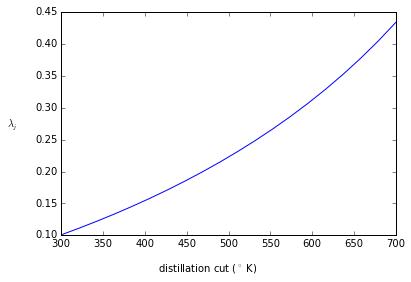

In [4]:
from pylab import *
%matplotlib inline

ax = subplot(111)

x = np.linspace(300.0, 700.0, 20)
y = Riazi.lamb(x)

plot(x, y, linewidth=1)

figtext(0.35, 0.0, r'distillation cut (${}^\circ$ K)')
figtext(0.0, 0.5, r'$\lambda_j$')

show()

and then $ K_{ow} $ then plots as a function of distillation cuts as:

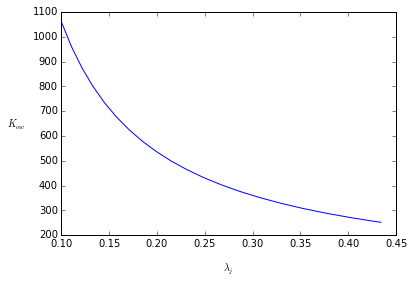

In [5]:
ax = subplot(111)

temps = np.linspace(300.0, 700.0, 20)
x = Riazi.lamb(temps)
y = LeeHuibers.partition_coeff(Riazi.mol_wt(temps),
                               Riazi.density(temps))

plot(x, y, linewidth=1)

figtext(0.5, 0.0, r'$\lambda_j$')
figtext(0.0, 0.5, r'$K_{ow}$')

show()

In order to calculate an overall $ K_{ow} $, it is necessary to do a molar average of the aromatic components.<br>
ADIOS3 stores the mass fraction, $ fmass_j $, of each component.

$$
\begin{align}
K_{ow} &= { \sum\limits_j {fmass_j \over molWt_j} \cdot K_{ow(j)} \over \sum\limits_j {fmass_j \over molWt_j} }
\end{align}
$$

and it is convenient to define:

$$
\begin{align}
\alpha_j &= { {fmass_j \over molWt_j} \over \sum\limits_j {fmass_j \over molWt_j} } \cr
&with... \cr
\sum\limits_j \alpha_j &= 1 \cr
\end{align}
$$

The preceding equation can then be written as:

$$
K_{ow} = \sum\limits_j \alpha_j \cdot K_{ow(j)}
$$

(TODO: Add a programmatic example here.)

The water phase transfer velocity $ k_w $ can be calculated for small buoyant droplets using Stoke's law, assuming steady-state velocity given by: 

$$
\begin{align}
\Delta_{\rho} &= \text{relative oil-water density difference} \cr
\delta_{drop} &= \text{droplet diameter} \cr
A_{drop} &= \text{droplet surface area} \cr
g &= \text{acceleration due to gravity} = 9.80665 (m/s^2) \cr
v_w &= \text{kinematic water viscosity } (m^2/s) \cr
\cr
k_w &= {1 \over 18\pi} \Delta_\rho \cdot {g \cdot A_{drop} \over v_w} \cr
&= {g \over 18 \pi \cdot v_w} \cdot \Delta_\rho \cdot A_{drop}  \cr
&\simeq 1.73 \cdot 10^5 \cdot \Delta_\rho \cdot A_{drop} \cr
\cr
&\text{and if we solve for diameter...} \cr
k_w &= {g \over 18 \pi \cdot v_w} \cdot \Delta_\rho \cdot A_{drop}  \cr
&= {g \over 18 \pi \cdot v_w} \cdot \Delta_\rho \cdot 4 \pi \left({\delta_{drop} \over 2}\right)^2 \cr
&= {g \over 4.5 \cdot v_w} \cdot \Delta_\rho \cdot \left({\delta_{drop} \over 2}\right)^2 \cr
\cr
&\simeq 2.18 \cdot 10^6 \cdot \Delta_\rho \cdot \left({\delta_{drop} \over 2}\right)^2 \cr
\end{align}
$$

Kinematic water viscosity $ v_w \simeq 1 $ centistoke at $ 20^\circ$C ($293^\circ$K, $68^\circ$F).

(<b>Note</b>: kinematic water viscosity actually ranges from about 0.8 to 1.7 cSt over a temperature range of $0^\circ$ to $30^\circ$ C.  This changes the numeric coefficient above from a range of 2.16e5 to 1.15e5.  This could be a problem as the range is significant.)<br>
Ref:<br>
<ul>
<li>http://www.engineeringtoolbox.com/water-dynamic-kinematic-viscosity-d_596.html</li>
<li>http://www.engineeringtoolbox.com/sea-water-properties-d_840.html</li>
</ul>

Some (sea)water viscosity correlations that we might be able to implement can be found here:<br>
<ul>
<li>http://web.mit.edu/lienhard/www/Thermophysical_properties_of_seawater-DWT-16-354-2010.pdf</li>
</ul>

This assumes spherical droplets with a droplet diameter $ \delta_{drop} $ less than 400 microns.  Droplets bigger than this will be distorted and rise more rapidly (Tkalich and Chan, 2002).  They are presumed by ADIOS3 to rise so quickly that little dissolution takes place for them except as part of the dissolution from the surface slick.

In [6]:
class Stokes(object):
    @classmethod
    def water_phase_transfer_velocity_1(cls, oil_water_rho_delta,
                                      diameter):
        surface_area = 4 * np.pi * (diameter / 2.0) ** 2
        return 1.73e5 * oil_water_rho_delta * surface_area
    
    @classmethod
    def water_phase_transfer_velocity_2(cls, oil_water_rho_delta,
                                        diameter):
        return 2.18e6 * oil_water_rho_delta * (diameter / 2.0) ** 2

Below is a plot of $ k_w $ (m/sec) versus droplet diameter (microns) for oil-water density difference equal to {0.1, 0.2, 0.3}.

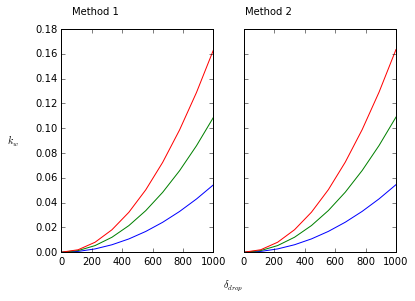

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

oil_water_rho_deltas = (0.1, 0.2, 0.3)
diameters = np.linspace(0.0, 1000, 10)

ax1.figure.text(0.15, 0.95, 'Method 1')
ax1.figure.text(0.55, 0.95, 'Method 2')
ax1.figure.text(0.5, 0.0, r'$\delta_{drop}$')
ax1.figure.text(0.0, 0.5, r'$k_{w}$')

for rdelta in oil_water_rho_deltas:
    k_w = Stokes.water_phase_transfer_velocity_1(rdelta,
                                                 diameters / 1.0e6)
    ax1.plot(diameters, k_w)

for rdelta in oil_water_rho_deltas:
    k_w = Stokes.water_phase_transfer_velocity_2(rdelta,
                                                 diameters / 1.0e6)
    ax2.plot(diameters, k_w)


## <u>Fate of surface oil in any time step</u>

The oil is assumed to be on the surface at the beginning of the time step.  The time step is assumed long compared to the time between breaking wave events.  When a breaking wave event occurs, the oil volume will be divided into three different pots, as shown in the figure below:

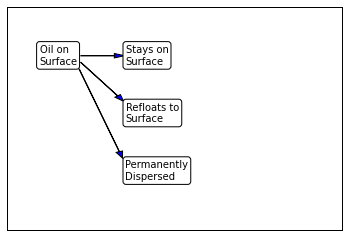

In [8]:
ax = subplot(111)
ax.set_yticks([])
ax.set_xticks([])

figtext(0.2, 0.7, 'Oil on\nSurface',
        bbox=dict(boxstyle='round', fc="w", ec="k"))
figtext(0.4, 0.7, 'Stays on\nSurface',
        bbox=dict(boxstyle='round', fc="w", ec="k"))
figtext(0.4, 0.5, 'Refloats to\nSurface',
        bbox=dict(boxstyle='round', fc="w", ec="k"))
figtext(0.4, 0.3, 'Permanently\nDispersed',
        bbox=dict(boxstyle='round', fc="w", ec="k"))

arrow(0.22, 0.78, 0.1, 0.0,)
arrow(0.22, 0.75, 0.11, -0.15,)
arrow(0.215, 0.72, 0.12, -0.37,)


## <u>Droplet size distribution</u>

Which pot gets what amount of oil depends upon droplet size.  Surface slicks hit by breaking waves will cause the oil to break into droplets given by a distribution function in size, $ \Bbb N(\delta_{drop})$, The total volume of oil insterted into the water column is then:

$$
\begin{align}
\delta_{max} &= \text{maximum droplet size} = 400 \text{microns} \cr
\delta_{min} &= \text{minimum droplet size} \cr
\cr
V_{drop} &= \int_{\delta_{min}}^{\delta_{max}} \Bbb N(\delta_{drop}) \cdot {\pi \cdot \delta_{drop}^3 \over 6} \cdot d(\delta_{drop}) \cr
\end{align}
$$

Minimum droplet size is discussed below.  These drops are inserted in a vertically uniform distribution into the water column to a depth of 1.5 times the height of the significant wave, $ H_{1/3} (m) $.<br>
ADIOS3 assumes a Pierson-Moskowitz spectrum for fully developed, wind induced, surface waves.  This relates significant wave height to $ U_{10} (m/s) $, which is the wind speed at 10m elevation.

$$
H_{1/3} \simeq 0.22 {U_{10}^2 \over g }
$$

 Peak wave period $T_w$(seconds) is given by

$$
T_w \simeq {3 \over 4} \cdot U_{10}
$$

In [9]:
class PiersonMoskowitz(object):
    @classmethod
    def significant_wave_height(cls, wind_speed):
        return (wind_speed ** 2.0) * 0.22 / 9.80665
    
    @classmethod
    def peak_wave_period(cls, wind_speed):
        return wind_speed * 3.0 / 4.0

print 'H_13 = ', PiersonMoskowitz.significant_wave_height(10.0)
print 'T_w = ', PiersonMoskowitz.peak_wave_period(10.0)

H_13 =  2.24337566855
T_w =  7.5


ADIOS3 needs the fraction of waves that break.<br>
Ding and Farmer (1993) note that the dependence of breaking wave properties on wind speed is quite scattered.<br>
According to Delvigne and Sweeney (1988) (DS), the fraction of breaking waves $f_{bw}$ is given by

$$
\begin{align}
f_{bw} &= {0.032 (U_{10} - 5) \over T_w} \cr
\end{align}
$$

In [10]:
class DelvigneSweeney(object):
    @classmethod
    def breaking_waves_frac(cls, wind_speed, peak_wave_period):
        return (wind_speed - 5.0) / peak_wave_period * 0.032

print DelvigneSweeney.breaking_waves_frac(10.0, 17.0)

0.00941176470588


DS assumes no breaking waves for winds less than 10 knots.  Lehr and Simecek-Beatty (2000) developed a slightly different formula that allowed breaking waves for winds as low as 6 knots.<br>
All these formulas may be modified as the new Katz experiment results become available and the ADIOS team replaces DS for natural surface dispersion.

The time period between breaking wave events, $T_{bw}$ (sec) is given by the wave period divided by the fraction of waves that break.

$$
T_{bw} = {T_w \over f_{bw}}
$$

Ding & Farmer (1993) note that the duration of the breaking event is about half the wave period, presumably $0.5 T_w$, although this is unclear from their text.<br>
Therefore, the time available (calm period) for the droplets to re-float is

$$
\begin{align}
T_{calm} &= T_{bw} - 0.5 T_w \cr
&= \left( {1 \over f_{bw}} - 0.5 \right) \cdot T_w
\end{align}
$$

Assuming that the 'average' droplet is inserted to a depth of $0.75 H_{1/3}$, then the average re-float time $T_{rfl}$ for the droplet is

$$
T_{rfl} = {3 \over 4} \cdot {H_{1/3} \over k_w}
$$

In [11]:
class DingFarmer(object):
    @classmethod
    def calm_between_wave_breaks(cls, breaking_waves_frac,
                                 peak_wave_period):
        return (1.0 / breaking_waves_frac - 0.5) * peak_wave_period

    @classmethod
    def refloat_time(cls, significant_wave_height,
                     water_phase_transfer_velocity):
        return (significant_wave_height / water_phase_transfer_velocity) * 3.0 / 4.0

wind_speed = 10.0 # m/s
rdelta = 0.2 # oil/water density difference
droplet_diameter = 0.0002 # 200 microns

wave_height = PiersonMoskowitz.significant_wave_height(wind_speed)
wave_period = PiersonMoskowitz.peak_wave_period(wind_speed)

f_bw = DelvigneSweeney.breaking_waves_frac(wind_speed, wave_period)
k_w = Stokes.water_phase_transfer_velocity_2(rdelta, droplet_diameter)

T_calm = DingFarmer.calm_between_wave_breaks(f_bw, wave_period)
T_rfl = DingFarmer.refloat_time(wave_height, k_w)

print '(wave_height, wave_period) = {}'.format((wave_height, wave_period))
print '(f_bw, k_w) = {}'.format((f_bw, k_w))
print ('calm between wave breaks = {}'.format(T_calm))
print ('refloat time = {}'.format(T_rfl))

(wave_height, wave_period) = (2.243375668551442, 7.5)
(f_bw, k_w) = (0.021333333333333333, 0.00436)
calm between wave breaks = 347.8125
refloat time = 385.901777847


The overall time scale is given by

$$
T_{bw} > T_{calm} > \left\{ T_{rfl}, T_w \right\}
$$

The time fraction that the droplet spends in the water column is given by the re-float time divided by the calm period between breaking wave events.

$$
\begin{align}
f_{wc} &= {T_{rfl} \over T_{calm}} \cr
&= {{3 \over 4} \cdot {H_{1/3} \over k_w} \over {\left( {1 \over f_{bw}} - 0.5 \right) \cdot T_w}} \cr
&= {{3 \over 4} \cdot {H_{1/3} \over k_w} \over {\left( {1 \over f_{bw}} - 0.5 \right) \cdot {3 \over 4} \cdot U_{10}}} \cr
&= {H_{1/3} \over k_w \left( {1 \over f_{bw}} - {1 \over 2}\right) \cdot U_{10}} \cr
\end{align}
$$

In [12]:
class Dissolution(Stokes, DingFarmer, DelvigneSweeney, PiersonMoskowitz):
    @classmethod
    def water_column_time_fraction_1(cls,
                                     wind_speed,
                                     oil_water_rho_delta,
                                     droplet_diameter):
        wave_period = cls.peak_wave_period(wind_speed)
        wave_height = cls.significant_wave_height(wind_speed)
        
        k_w = cls.water_phase_transfer_velocity_2(oil_water_rho_delta,
                                                  droplet_diameter)
        f_bw = cls.breaking_waves_frac(wind_speed, wave_period)

        T_rfl = cls.refloat_time(wave_height, k_w)
        T_calm = cls.calm_between_wave_breaks(f_bw, wave_period)

        return T_rfl / T_calm

    @classmethod
    def water_column_time_fraction_2(cls,
                                     wind_speed,
                                     oil_water_rho_delta,
                                     droplet_diameter):
        wave_period = cls.peak_wave_period(wind_speed)
        wave_height = cls.significant_wave_height(wind_speed)

        k_w = cls.water_phase_transfer_velocity_2(oil_water_rho_delta,
                                                  droplet_diameter)
        f_bw = cls.breaking_waves_frac(wind_speed, wave_period)

        return (wave_height /
                (k_w * (1.0 / f_bw - 0.5) * wind_speed))

wind_speed = 10.0 # m/s
rdelta = 0.2 # oil/water density difference
droplet_diameter = 0.0002 # 200 microns

print Dissolution.water_column_time_fraction_1(wind_speed, rdelta, droplet_diameter)
print Dissolution.water_column_time_fraction_2(wind_speed, rdelta, droplet_diameter)

1.10951095158
1.10951095158


## <u>Dispersion degression</u>

If $f_{wc} \geq 1 $, then the droplet is permanently dispersed, providing a new formula to define maximum dispersed oil droplet size.

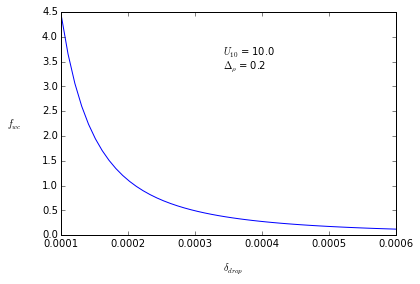

In [13]:
ax = subplot(111)

wind_speed = 10.0 # m/s
rdelta = 0.2 # oil/water density difference

x = np.linspace(0.0001, 0.0006, 50)
y = Dissolution.water_column_time_fraction_2(wind_speed, rdelta, x)

plot(x, y, linewidth=1)

figtext(0.5, 0.75, r'$U_{10}$' + ' = {}'.format(wind_speed))
figtext(0.5, 0.7, r'$\Delta_{\rho}$' + ' = {}'.format(rdelta))

figtext(0.5, 0.0, r'$\delta_{drop}$')
figtext(0.0, 0.5, r'$f_{wc}$')

show()

<hr size="5" >

For dissolution directly from the surface slick, the mean drift velocity of the slick with respect to the water will be approximately 3% of the mean wind speed at 10m elevation $U_{10}$.  The mass transfer coefficient will be less than this due to the fact that much of the slick will be moving over water already containing dissolved oil.<br>
In this respect, dissolution is similar, but smaller than surface evaporation.<br><br>
A possible formula for the mass transfer rate (per unit area) directly from the slick subsurface would be

$$
\begin{align}
c_{oil} &= \text{saturation concentration in oil??} (kg/m^3) \cr
A_{slick} &= \text{subsurface area of slick} (m^2) \cr
S_c &= \text{Schmidt number} \cr
N_s &= \text{slick subsurface mass transfer rate} \cr
\cr
N_s &= 0.03 U_{10} \cdot {c_{oil}(j) \over K_{ow}(j)} \cdot \left( A_{slick} \over \pi \right)^{-0.11} \cdot S_c^{-2/3} \cr
\end{align}
$$

Louis Thibodeaux has kindly given us advice regarding the estimation of the Schmidt number.<br>
The Schmidt Number is equal to the kinematic viscosity of water $v_w (m^2/s)$ divided by the molecular diffusivity of solute in water $D_{sw} (m^2/s)$ at the same temperature.  Typical $S_c$ values are approximately 1000.<br>
Some specific values:
<ul>
    <li>phenol = 1200</li>
    <li>butanol = 1310</li>
    <li>hydrogen sulfide = 657</li>
</ul>

In [14]:
def slick_subsurface_mass_transfer_rate(concentration_in_oil,
                                        partition_coeffient,
                                        slick_area,
                                        schmidt_number=1000.0):
    c_oil = concentration_in_oil
    k_ow = partition_coeffient
    s_c = schmidt_number

    return 0.03 * wind_speed * (c_oil / k_ow) * (slick_area / np.pi) ** (-0.11) * s_c ** (-2.0/3.0)

slick_area = 10000  # m^2
c_oil = 10.0  # need a good value here.  Is saturation concentration in oil an input??
cut_temperature = 400.0

k_ow = LeeHuibers.partition_coeff(Riazi.mol_wt(cut_temperature),
                                  Riazi.density(cut_temperature))

print slick_subsurface_mass_transfer_rate(c_oil, k_ow, slick_area)

1.78596471203e-05


Dissolution from the surface slick will only occur during the calm period $T_{calm}$.

For dissolution from droplets, droplet sizes and densities change due to dissolution. As well as recording the volume of oil that dissolves, the model also adjusts the size and buoyancy of the new droplet for purposes of buoyancy.<br>
Define $\{ V_{dis}, V_{inert} \}$ as the respective dissolvable and inert volumes of oil, here assumed to be a subsurface droplet of volume $V_{drop}$.

$$
V_{drop} = V_{dis} + V_{inert}
$$

and

$$
V_{dis} = \sum_j V_j
$$

Where $j$ is the subscript of the jth aromatic distillation cut.<br>
All the other SARA cuts (saturates, resins, asphaltenes) make up the inert volume of the drop that does not change over time.<br>
A necessary assumption here is that the different volume fractions do not act as solvents for other fractions.
This is not strictly true as, for example, the aromatics can act as the solvent for the asphaltenes, and volume may not be conserved in such circumstances.

Similarly, $\{ \rho_{dis}, \rho_{inert} \}$ define the respective densities with

$$
\rho_{dis} = \sum_j \alpha_j \rho_j
$$

Since the inert volume is fixed, we can define a new state variable

$$
\begin{align}
X(t) &= { V_{dis}(t) \over V_{inert} } \;\;\text{ with}\;\; V_{drop} = V_{inert} \cdot (X + 1) \cr
\cr
m_{drop}(t) &= \rho_{dis}(t) V_{dis}(t) + \rho_{inert} V_{inert} \cr
&= V_{inert} \cdot \left( \rho_{dis} \cdot X(t) + \rho_{inert} \right) \cr
\end{align}
$$

Then the mass rate equation can be written as

$$
\begin{align}
{dm_{drop} \over dt} &= {d \over dt}(m_{drop}(t)) \cr
&= V_{inert} {d \over dt} \left( \rho_{dis} \cdot X(t) \right) \cr
&= -N \cdot A_{drop} \cr
\cr
A_{drop} &= \text{droplet surface area} \cr
\end{align}
$$

The two time derivative terms, $ \left\{ {d \rho_{dis} \over dt}, {dX \over dt} \right\} $ vary for different reasons.<br>
The first derivative reflects the fact that the dissolvable volume fraction is changing its composition over time.<br>
The second derivative reflects the fractional loss of the total dissolvable volume.<br>
In the simplest case, the dissolvable fraction density does not change significantly and its derivative can be neglected.  This is the option used by Stevens et al (2015) in their binary mixture model.

This seems a reasonable approximation if one considers the longer term changes in the oil since

$$
\int {d \rho_{dis} \over \rho_{dis}} \ll \int {dX \over X}
$$

as the dissolvable fraction approaches zero.

The mass transfer rate, N, is a function of the dissolvable oil concentration.

$$
\begin{align}
C_{dis} &= \text{dissolvable oil concentration} \cr
N &= {k_w \over K_{ow}} C_{dis} \cr
&= {k_w \over K_{ow}} \cdot { X \over (X + 1)} \cdot \rho_{dis} \cr
& \text{Soooo...??} \cr
C_{dis} &= { X \over (X + 1)} \cdot \rho_{dis} \cr
\end{align}
$$

And combining 1.2(???) and 1.3(???) gives

$$
{dX \over dt} = -{k_w \over K_{ow}} \cdot {X \over (X + 1)} \cdot A_{drop}
$$

For an oil droplet assumed to approximate a perfect sphere, the surface area can also be related to X as well

$$
\begin{align}
A_{drop} &= 4 \pi \cdot \left( {3 \over 4 \pi} \right)^{2/3} \cdot V_{drop}^{2/3} \cr
&\simeq 4.84 \cdot V_{drop}^{2/3} \cr
&\simeq 4.84 \cdot V_{inert}^{2/3} \cdot (X + 1)^{2/3} \cr
\cr
{dX(t) \over dt} &= -{k_w \over K_{ow}} \cdot {X \over (X + 1)} \cdot A_{drop} \cr
&= -{k_w \over K_{ow}} \cdot {X \over (X + 1)} \cdot 4.84 \cdot V_{inert}^{2/3} \cdot (X + 1)^{2/3} \cr
&= -4.84 {k_w \over K_{ow}} \cdot V_{inert}^{2/3} \cdot {X \over (X + 1)} \cdot (X + 1)^{2/3} \cr
&= -4.84 {k_w \over K_{ow}} \cdot V_{inert}^{2/3} \cdot X \cdot (X + 1)^{-1} \cdot (X + 1)^{2/3} \cr
&= -4.84 {k_w \over K_{ow}} \cdot V_{inert}^{2/3} \cdot X \cdot (X + 1)^{-1/3} \cr
\cr
{dX(t) \over dt} &= \beta \cdot {X \over (X + 1)^{1/3}} \cr
&\text{where...} \cr
\beta &= -4.84 {k_w \over K_{ow}} \cdot V_{inert}^{2/3} < 0
\end{align}
$$

## <u>Surface Slicks</u>

For surface slicks, the oil droplet size and composition will not change significantly over the model time step, $\Delta t$.

The droplets created by the breaking waves will be 'binned' according to their droplet diameter with $N(i)$ representing the number of droplets in bin size $i$ with $i = 1...i_{max}$.<br>
$N(i)$ is generated from the surface dispersion formulas (ADIOS2 uses Delvigne-Sweeney).

The total oil volume of the sub-surface droplets $V_{sub}$ is given by

$$
V_{sub} = \sum_i V_i \cdot N(i)
$$

Note that we assume the SARA composition at the beginning of the time step is the same for each drop, regardless of its size.<br>
Then

$$
\begin{align}
X_{sub}(t) &= X_i(t) \; \forall i \cr
\cr
&\text{and}
\cr
X_i(t + \Delta t) &= X_i(t) + f_{wc}(i) \cdot \beta_i \cdot {X_{sub}(t) \over \left( X_{sub}(t) + 1 \right)^{1/3}} \cdot \Delta t \cr
\cr
\Delta V_{drop}(\Delta t) &= \sum_i N(i) \cdot V_{inert}(i) \cdot \left[ X_i(t + \Delta t) - X_{sub}(t) \right]
\end{align}
$$

where $\Delta V_{drop}(\Delta t)$ represents the oil volume dissolved from droplets in the model time step.

Volume loss directly from the surface slick can be approximated as

$$
\Delta V_{surf} = N_s \cdot \rho_{dis} \cdot \Delta t
$$

and the total volume dissolved is

$$
\Delta V_{tot} = \Delta V_{drop} + \Delta V_{surf}
$$

## <u>Sub-surface Release</u>

For this case, $X_i(t)$ as $t$ gets larger is not the same for all droplet sizes.<br>
The Boundary condition is

$$
X = X_0 \;\text{at}\; t = 0
$$

with limiting condition that $X \leq X_0 \;\forall\; t > 0$ and $X \to 0$ as $t \to \infty$

The dynamic equation can be written as

$$
\int_{X_0}^X {(X + 1)^{1/3} \over X} \cdot dX = \beta t
$$

An exact, but complex, solution exists for the above equation.  However, since its construction already incorporates many idealizations, added complexity probably does not contribute to a more accurate model.<br>
Therefore, rather than using the complex solution, an approximate solution can be found by considering the limits of the integrand.

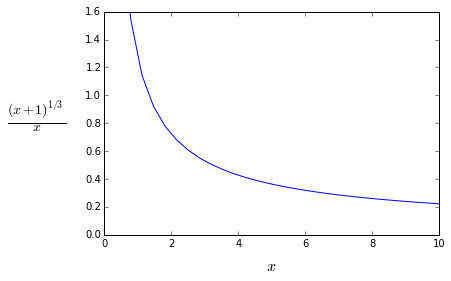

In [15]:
ax = subplot(111)

x = np.linspace(0.1, 10.0, 30)
y = (x + 1) ** (1.0 / 3.0) / x

plot(x, y, linewidth=1)
ylim([0, 1.6])

figtext(0.5, 0.0, r'$x$', fontsize=16)
figtext(-0.1, 0.5, r'$\frac{(x + 1)^{1/3}} {x}$', fontsize=20)


$$
\begin{align}
{(X + 1)^{1/3} \over X} \to {1 \over 0} \to \infty \;as\; X \to 0 \cr
{(X + 1)^{1/3} \over X} \to {1 \over X^{2/3}} \to 0 \;as\; X \to \infty \cr
\end{align}
$$

We can then replace

$$
{(X + 1)^{1/3} \over X} \to {1 \over 2^{2/3}} \left({1 \over X} H(1 - X) + {1 \over X^{2/3}} H(X - 1) \right)
$$

where $H(X)$ is the Heaviside function.  This matches the original and approximate function at $X = 1$.

In [23]:
def heavi(t, c=0):
    return float(t >= c)

def heavi_x(x):
    return 1.0 / 2.0 ** (2.0 / 3.0) * (1.0 / x * heavi(1.0, x) + 1.0 / x ** (2.0 / 3.0) * heavi(x, 1.0))

def norm_x(x):
    return (x + 1.0) ** (1./3.) / x

# Note: Bill, do these numbers look reasonable??
print 1.0, (norm_x(1.0), heavi_x(1.0))
print
for x in np.linspace(0.01, 2, 20):
    print x, (norm_x(x), heavi_x(x))


1.0 (1.2599210498948732, 1.2599210498948732)

0.01 (100.33222835420892, 62.996052494743658)
0.114736842105 (9.0369363958408133, 5.4904816394501355)
0.219473684211 (4.867900473084779, 2.870323734772493)
0.324210526316 (3.3870782812733755, 1.9430600607144959)
0.428947368421 (2.6258388519751166, 1.4686196287118154)
0.533684210526 (2.1608649647961906, 1.1803994057200489)
0.638421052632 (1.8465793445707264, 0.98674773075031286)
0.743157894737 (1.6194385750235742, 0.84768059305958177)
0.847894736842 (1.447273033174582, 0.74297020322788931)
0.952631578947 (1.312044189588691, 0.66128452895034784)
1.05736842105 (1.2028487485716228, 0.60696331874825027)
1.16210526316 (1.1127052655395591, 0.56992322785321359)
1.26684210526 (1.0369343649104974, 0.53806120099582111)
1.37157894737 (0.9722808195449153, 0.51030849257788147)
1.47631578947 (0.91640913767356358, 0.48587791569681804)
1.58105263158 (0.86759949949942894, 0.46417575374142706)
1.68578947368 (0.82455694014772152, 0.44474503769685986)
1.7905263

Then the equation can be approximately solved for low solubility oils as

$$
\begin{align}
\int_{X_0}^X {(X + 1)^{1/3} \over X} \cdot dX &\simeq \int_{X_0}^X {1 \over 2^{2/3} X} \cdot dX \cr
&\simeq {1 \over 2^{2/3}} ln \left( {X \over X_0} \right) \;\;\forall\; X_0 < 1 \cr
\end{align}
$$

This yields the solution

$$
\begin{align}
X &= X_0 e^{2^{2/3} \beta t} \cr
&= X_0 e^{1.6 \beta t} \cr
\end{align}
$$

If however the initial condition is such that the dissolvable volume is larger than the inert volume (e.g. gasoline spills), then $X_0 > 1$ and we would use

$$
\int_{X_0}^X {(X + 1)^{1/3} \over X} \cdot dX \simeq \int_{X_0}^X X^{-2/3} \cdot dX \;\;\;\forall\; X_0 \gg 1
$$

This yields the solution

$$
X \simeq \left( X_0^{1/3} + {1 \over 5} \beta t \right)^3
$$

<br>
For $X$ close to 1, the answer is between the two extremes.

## <u>Programming Instructions (still in a very draft stage)</u>

<i>SURFACE SLICKS ONLY (ADIOS3/GNOME2 does not support subsurface spills yet)</i>

The calculation of $K_{ow}$ is only weakly time-dependent, changing as the various SARA mass fractions change.
Therefore it is probably sufficient to recalculate $K_{ow}$ every $n_{step}$ where a first guess might be $n_{step} = 100$.  Use formula in Equation 1.8.